## Cropping modulator
#### Croppar mekaniskt ut svarta ramar ur bilderna

<img src="images/skiss.png" alt="alt text" width="500"/>

In [162]:

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import numpy as np
import cv2
import pandas as pd
import seaborn as sns


## Sätt källa och destination 
#### (glöm inte avkommentera source och dest med rätt sökväg!)

In [198]:
#sätt source o destinatiom
# source_root = pathlib.Path(r'C:\Users\AndreasP\Desktop\StudieGrupp3_MLProjekt\data\raw\dataset_1\no')
# dest_root = pathlib.Path(r'C:\Users\AndreasP\Desktop\cropped_no')
type_analyse = source_root.name
type_analyse

'no'

### find_margins är metod till croppingtekniken

In [199]:
def find_margins(arr_2D):
    x_margin_left = 0
    x_margin_right = 0
    y_margin_top = 0
    y_margin_bottom = 0
    threshold = 1000                                                    
    box_precentage = 0.15                                               # hur storarekktanglar vill vi saxa ur hörnen
    original_height, original_width = arr_2D.shape
    
    height_box = int(box_precentage * original_height)                  # tar ut ett procentuellt mått på höjden 
    width_box = int(box_precentage * original_width)                    # tar ut ett procentuellt mått på bredden 

    #--------------Maskar ur boxar i hörnen ------------
    arr_2D[:height_box, :width_box] = 0                                 # sätter rektangel top left = 0
    arr_2D[:height_box, original_width - width_box:] = 0                  # sätter rektangel top right = 0
    arr_2D[original_height - height_box:, :width_box] = 0                 # sätter rektangel bottom left = 0
    arr_2D[original_height - height_box:, original_width - width_box:] = 0  # sätter rektangel bottom right = 0


    #----------summerar längs x-axel o returnerar värde där vi träffar threshold
    x_sum = np.sum(arr_2D, axis = 0)                                     # summerar längs x
    if x_sum[0] == 0:                                                    # måste testa med 0, för att undvika error
        x_margin_left = np.nonzero(x_sum > threshold)[0][0]              # returnerar index där vi passerat tröskelvärde
    reversed_x_arr = x_sum[::-1]                                         # vänder på np o upprepar
    if reversed_x_arr[0] == 0:
        x_margin_right = np.nonzero(reversed_x_arr > threshold)[0][0]

    #----------summerar längs y-axel oreturnerar värde där vi träffar threshold
    y_sum = np.sum(arr_2D,axis = 1)                                     # summerar längs Y
    if y_sum[0] == 0:                                                   # måste testa med 0, för att undvika error
        y_margin_top = np.nonzero(y_sum > threshold)[0][0]              # returnerar index där vi passerat tröskelvär
    reversed_y_arr = y_sum[::-1]                                        # vänder på np o upprepar
    if reversed_y_arr[0] == 0:
        y_margin_bottom = np.nonzero(reversed_y_arr > threshold)[0][0]

    return x_margin_left, x_margin_right, y_margin_top, y_margin_bottom        # returnerar alla ytterkoordinater

### Hämtar ut alla filer ur source mappen och lägger i lista

In [200]:
temp_list = []
p1 = source_root.glob('*/')
file_paths = [x for x in p1 if x.is_file()]
for file_p in file_paths:
    temp_list.append(file_p)
print("antal filer:", len(temp_list))

antal filer: 76


### Bearbetar varje bild och sparar ner modifierad version på platsen 'dest_root'

In [201]:
for f in temp_list:
    image = cv2.imread(str(f))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_shape = gray.shape
    frame = 3                                                       #antalet pixlar i ran runt bild som croppas initialt

    thresh_arr = gray.ravel()

   # t = [255 if thresh> 40 else 0 for thresh in thresh_arr]         # sätter kontrastgränsen på 40. < 40 = 0 :: > 40 = 255
   # t = np.array(t)

    thresh_arr = np.where(thresh_arr < 40, 0, thresh_arr)           # the numpy way... 
    t = np.where(thresh_arr != 0, 255, thresh_arr)                  # val < 40 = 0   ::: allt annat 255




    t = t.reshape(original_shape)
    t_frame = t[frame:-frame, frame:-frame]                         # klipper av alla kanter direkt
    x_left, x_right, y_top, y_bottom = find_margins(t_frame)        # marginaler returnaras. metoden finns en bit upp 

    original_y, original_x = original_shape                         # original måtten på bild
    y_b = original_y - y_bottom                                     # måttet på hur mkt som ska behövas i y-led
    x_r = original_x - x_right                                      # måttet på hur mkt som ska behövas i x-led

    
    new_image = image[y_top + frame:y_b - frame, x_left + frame:x_r - frame]    # här appliceras frame på alla mått
    
    save_path = dest_root / f.name                                      # sparar ner filen mend samma namn i dest mappen 
    
    imx = Image.fromarray(new_image)
    imx.save(save_path)
    

--------------------

---------------------

## Plockar ut alla filer ur destinationen för att printa 'blackness'
### (glöm inte avkommentera dest med rätt sökväg)

In [232]:
# dest_root = pathlib.Path(r'C:\Users\AndreasP\Desktop\cropped_yes')
type_analyse = dest_root.name

In [233]:
temp_list = []
temp_list_fname = []
p1 = dest_root.glob('*/')
file_paths = [x for x in p1 if x.is_file()]
for file_p in file_paths:
    temp_list.append(file_p)
    temp_list_fname.append(file_p.name)

temp_list[0]

WindowsPath('C:/Users/AndreasP/Desktop/cropped_yes/Y1.jpg')

### prc_lst kommer fyllas på med blackness-procent per bild

In [234]:
prc_lst = []
for f in temp_list:
    image = cv2.imread(str(f))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_shape = gray.shape
    thresh_arr = gray.ravel()
    #t = [255 if thresh> 40 else 0 for thresh in thresh_arr]         # sätter kontrastgränsen på 40. < 40 = 0 :: > 40 = 255
    
    thresh_arr = np.where(thresh_arr < 40, 0, thresh_arr)           # sätter kontrastgränsen på 40. < 40 = 0 :: > 40 = 255
    t = np.where(thresh_arr != 0, 255, thresh_arr)                  # jobbar med numpy  pga hastighet 
    
    
    
    #t = np.array(t)
    zeros = np.count_nonzero(t == 0)
    perc = zeros/ len(t)
    prc_lst.append(perc)
    
   

In [235]:
prc_lst = np.array(prc_lst)

mean_lst = prc_lst.mean()
mean_std_line = prc_lst.mean() + prc_lst.std()*2
mean_std_line

0.4692837647105024

### skapar en mask för att skilja plottarna åt

In [236]:
mean_o = mean_lst + prc_lst.std()
mean_u =  mean_lst - prc_lst.std()
mask = [0 if q > mean_u and q < mean_o else 1 for q in prc_lst]
mask = np.array(mask).astype(bool)
mask_inv = ~mask


### Skapar en plot med bilderna

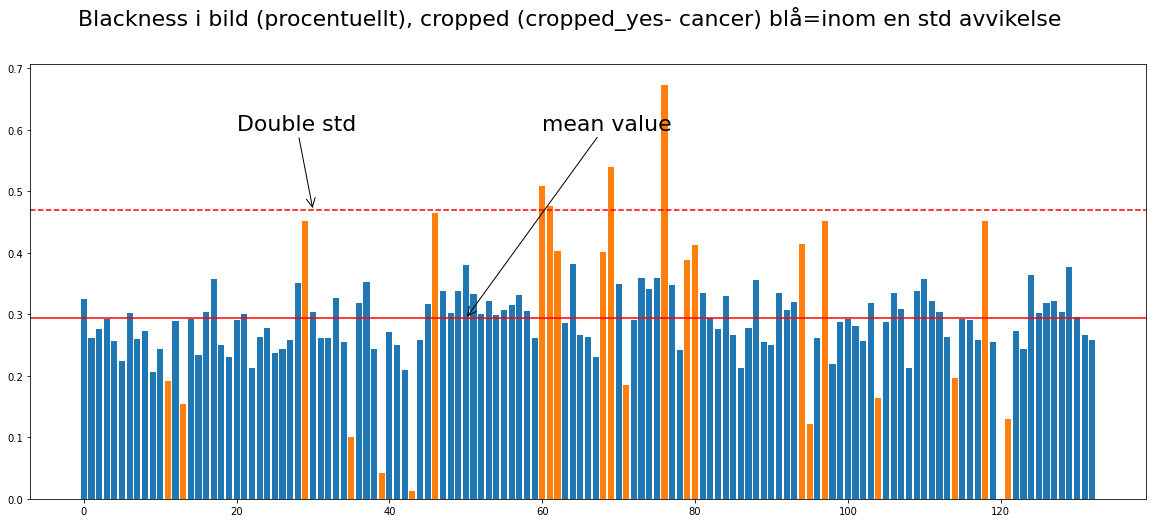

In [237]:
fig, ax = plt.subplots(figsize = (20, 8))
x_ax = np.arange(len(prc_lst))
lst1 = mask * prc_lst
lst2 = mask_inv * prc_lst
fig.suptitle(f"Blackness i bild (procentuellt), cropped ({type_analyse}- cancer) blå=inom en std avvikelse", fontsize = 22)
ax.bar(x_ax, lst2)
ax.bar(x_ax, lst1)


ax.annotate("Double std", xy = (30, mean_std_line), xytext = (20, 0.6),
            arrowprops = dict(arrowstyle="->"), fontsize = 22)
ax.annotate("mean value", xy = (50, mean_lst), xytext = (60,0.6),
            arrowprops = dict(arrowstyle = "->"), fontsize = 22)          
ax.axhline(y = mean_lst, color = 'r', linestyle = '-')
ax.axhline(y = mean_std_line, color = 'r', linestyle = '--')


In [238]:
df = pd.DataFrame()
df['complete_path'] = temp_list
df['file'] = temp_list_fname
df['blackness'] = prc_lst
cond = df['blackness'] >= mean_std_line
temp_df= df[cond]
temp_df


,complete_path,file,blackness
60,C:\Users\AndreasP\Desktop\cropped_yes\Y244.JPG,Y244.JPG,0.508300
61,C:\Users\AndreasP\Desktop\cropped_yes\Y245.jpg,Y245.jpg,0.475369
69,C:\Users\AndreasP\Desktop\cropped_yes\Y252.jpg,Y252.jpg,0.539919
76,C:\Users\AndreasP\Desktop\cropped_yes\Y259.JPG,Y259.JPG,0.673359


4


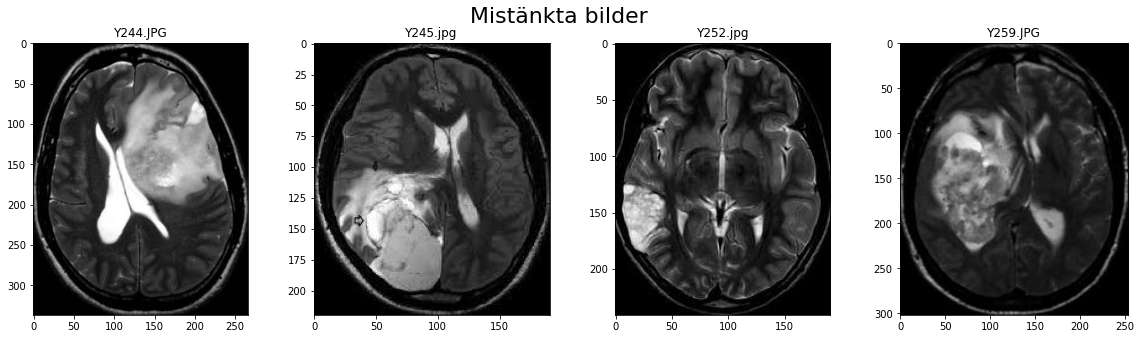

In [239]:
l_df=len(temp_df)
print(l_df)
if l_df < 7:
    fig, ax = plt.subplots(1, l_df,figsize=(20,5))
    fig.suptitle("Mistänkta bilder",fontsize = 22)
    for idx, f in enumerate(temp_df['complete_path']):
        image = cv2.imread(str(f)) 
        ax[idx].imshow(image)
        ax[idx].set_title(f.name)